  1. Load Dataset

In [3]:
# Importing the essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing essentials from Scikit-Learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# XGBoost and LightGBM models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# This for a cleaner output
import warnings
warnings.filterwarnings('ignore')

# Check versions
import sklearn
print(f"scikit-learn version: {sklearn.__version__}")
import xgboost
print(f"xgboost version: {xgboost.__version__}")
import lightgbm
print(f"lightgbm version: {lightgbm.__version__}")

scikit-learn version: 1.6.1
xgboost version: 3.1.1
lightgbm version: 4.6.0


In [4]:
df = pd.read_csv('energydata_complete[1].csv', parse_dates=['date'])
print(f"Original data shape: {df.shape}")

Original data shape: (19735, 29)


In [5]:
df['Appliances_log'] = np.log1p(df['Appliances'])

In [6]:
df['hour'] = df['date'].dt.hour
df['weekday'] = df['date'].dt.weekday
df['month'] = df['date'].dt.month

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 33 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            19735 non-null  datetime64[ns]
 1   Appliances      19735 non-null  int64         
 2   lights          19735 non-null  int64         
 3   T1              19735 non-null  float64       
 4   RH_1            19735 non-null  float64       
 5   T2              19735 non-null  float64       
 6   RH_2            19735 non-null  float64       
 7   T3              19735 non-null  float64       
 8   RH_3            19735 non-null  float64       
 9   T4              19735 non-null  float64       
 10  RH_4            19735 non-null  float64       
 11  T5              19735 non-null  float64       
 12  RH_5            19735 non-null  float64       
 13  T6              19735 non-null  float64       
 14  RH_6            19735 non-null  float64       
 15  T7

In [8]:
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

In [9]:
# Cyclical encoding for month (1–12) and weekday (0–6)
df['month_sin']   = np.sin(2 * np.pi * df['month'  ] / 12)
df['month_cos']   = np.cos(2 * np.pi * df['month'  ] / 12)
df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)


2. Exploratory Data Analysis (EDA)

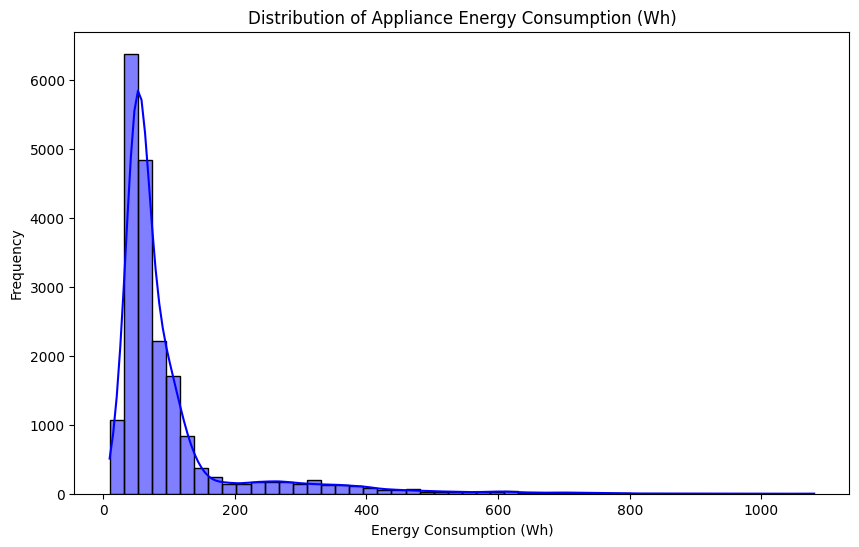

In [10]:
plt.figure(figsize=(10,6))
sns.histplot(df['Appliances'], bins=50, kde=True, color='blue')
plt.title('Distribution of Appliance Energy Consumption (Wh)')
plt.xlabel('Energy Consumption (Wh)')
plt.ylabel('Frequency')
plt.show()

In [11]:
print(df['Appliances'].describe())

count    19735.000000
mean        97.694958
std        102.524891
min         10.000000
25%         50.000000
50%         60.000000
75%        100.000000
max       1080.000000
Name: Appliances, dtype: float64


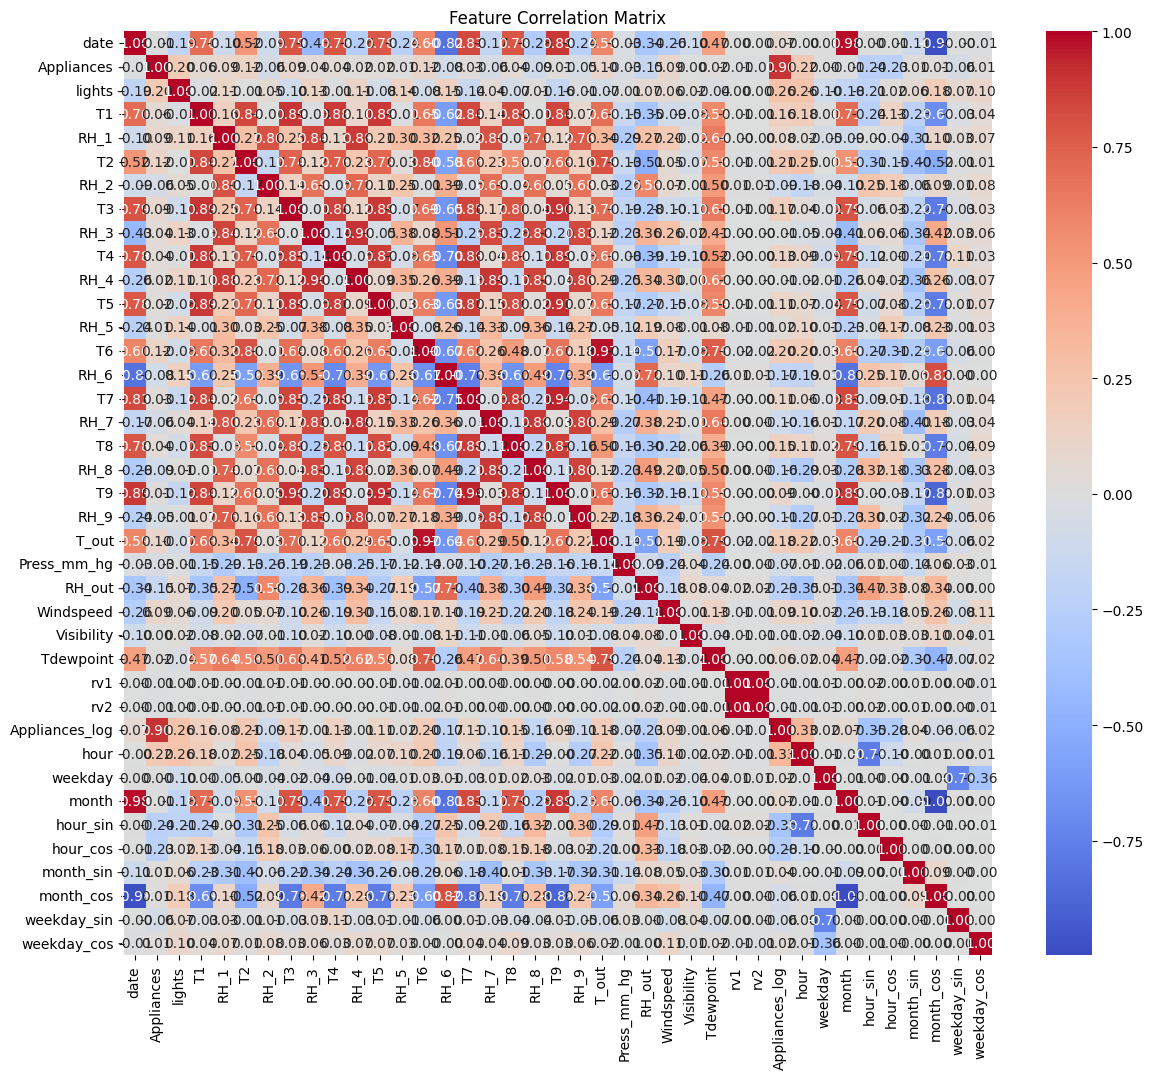

In [12]:
plt.figure(figsize=(14,12))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

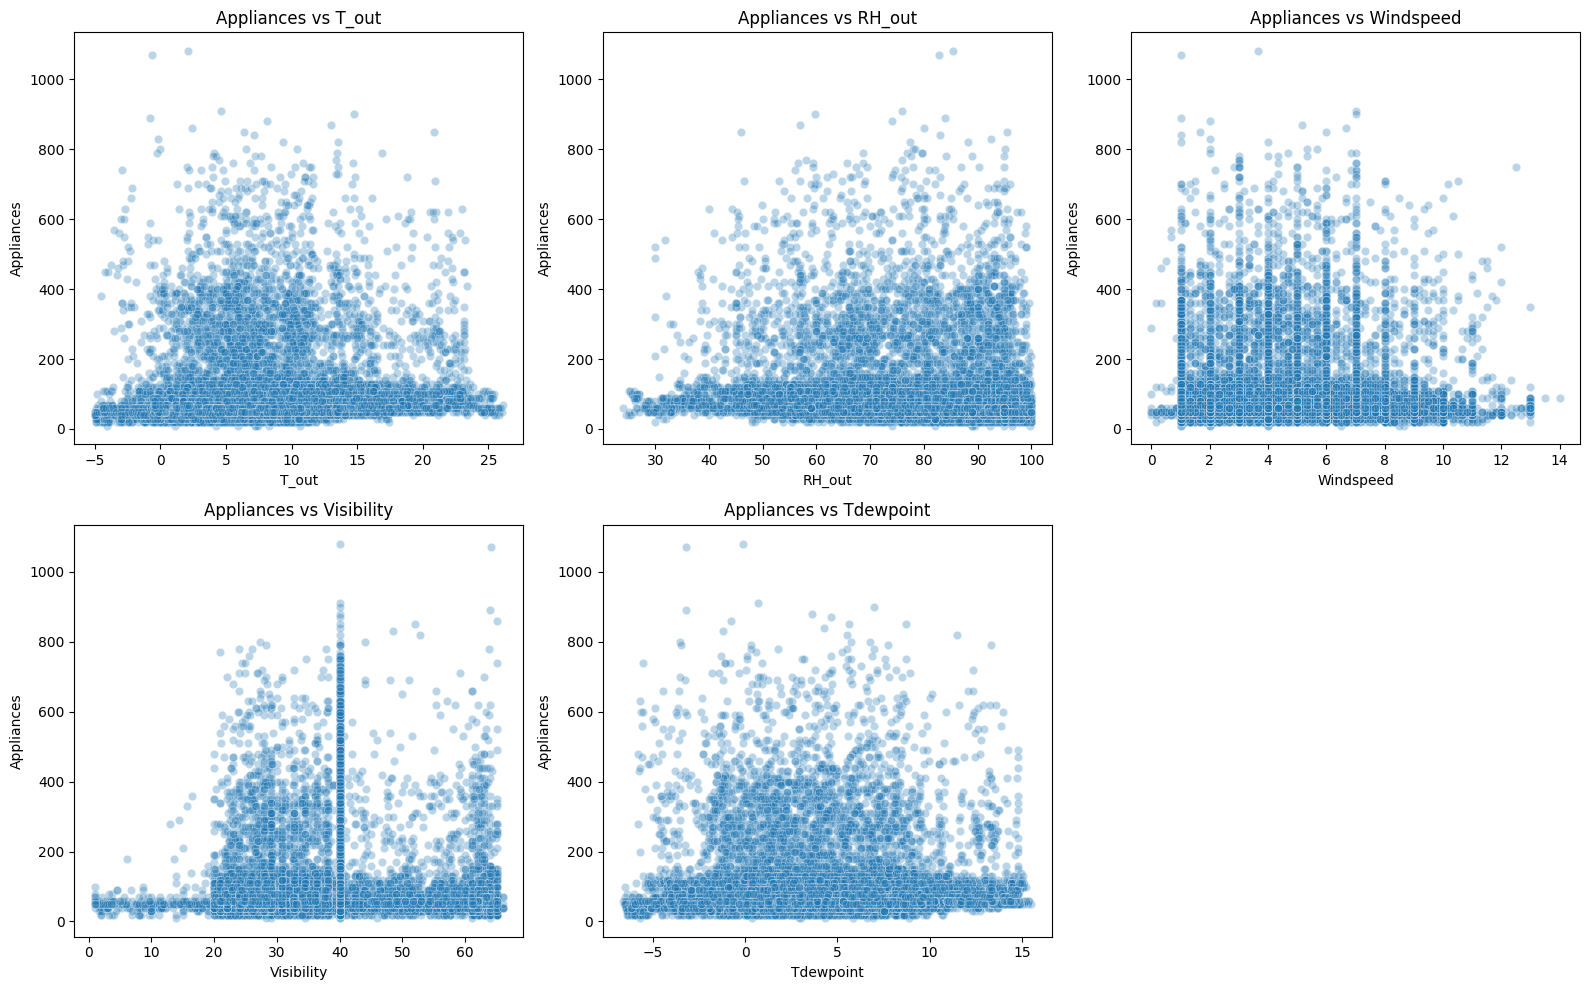

In [13]:
top_features = ['T_out', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint']

plt.figure(figsize=(16, 10))
for i, feature in enumerate(top_features):
    plt.subplot(2, 3, i+1)
    sns.scatterplot(x=df[feature], y=df['Appliances'], alpha=0.3)
    plt.title(f'Appliances vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Appliances')
plt.tight_layout()
plt.show()

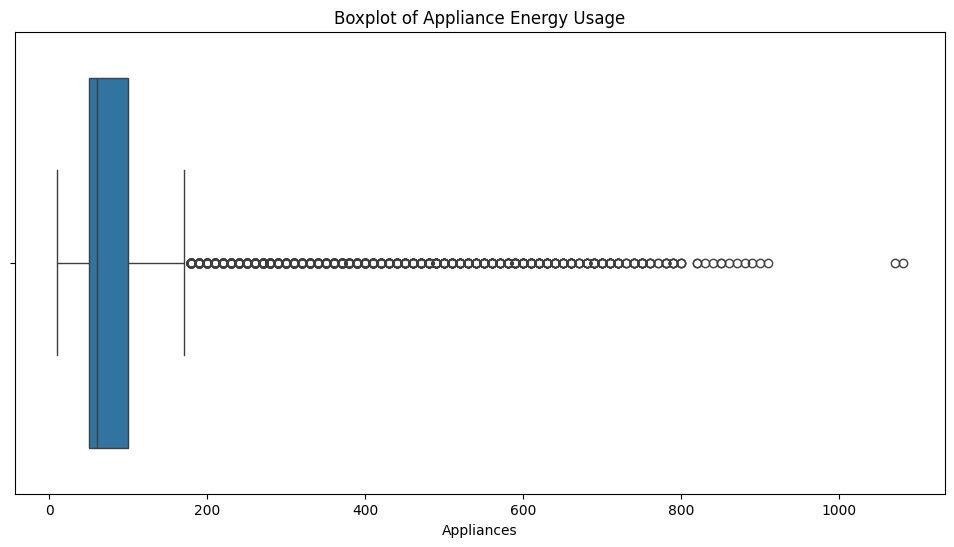

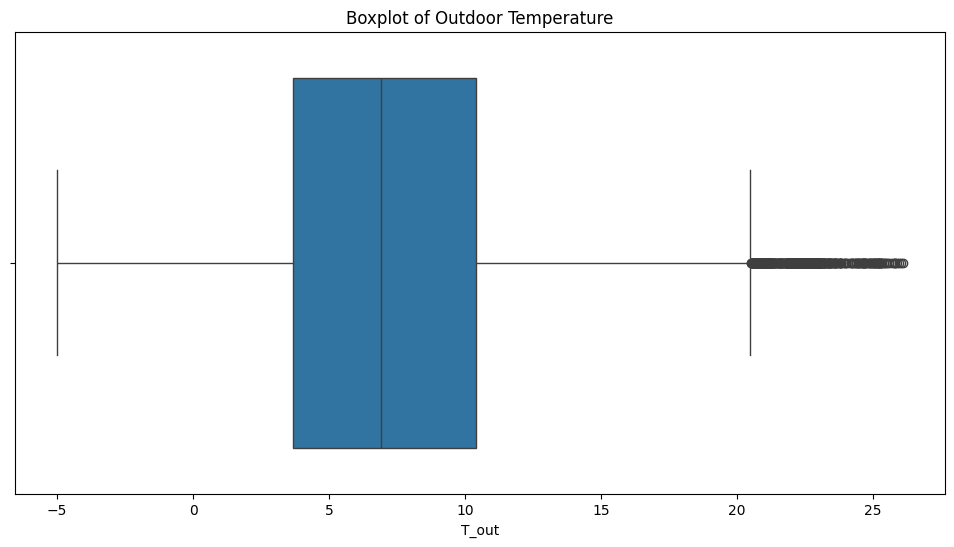

In [14]:
plt.figure(figsize=(12,6))
sns.boxplot(x=df['Appliances'])
plt.title('Boxplot of Appliance Energy Usage')
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(x=df['T_out'])
plt.title('Boxplot of Outdoor Temperature')
plt.show()

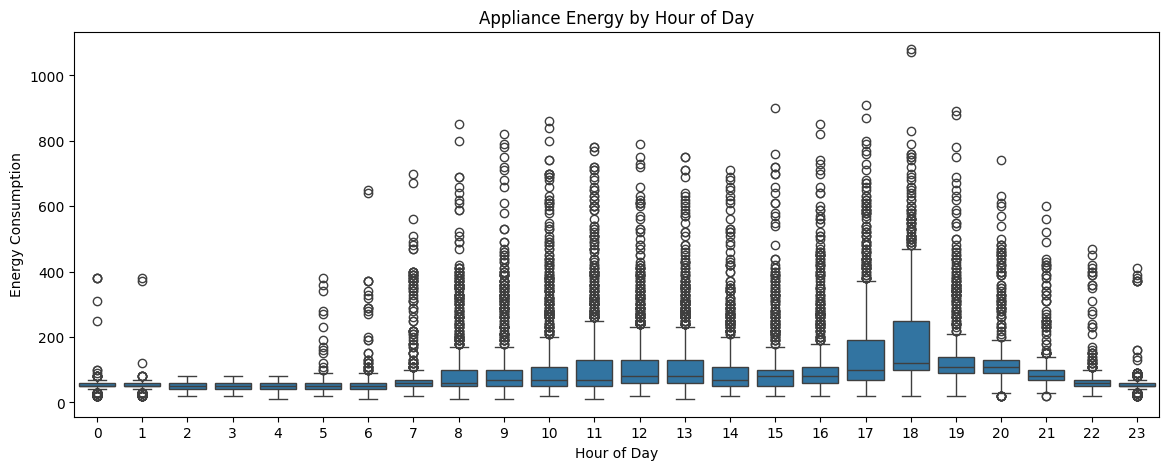

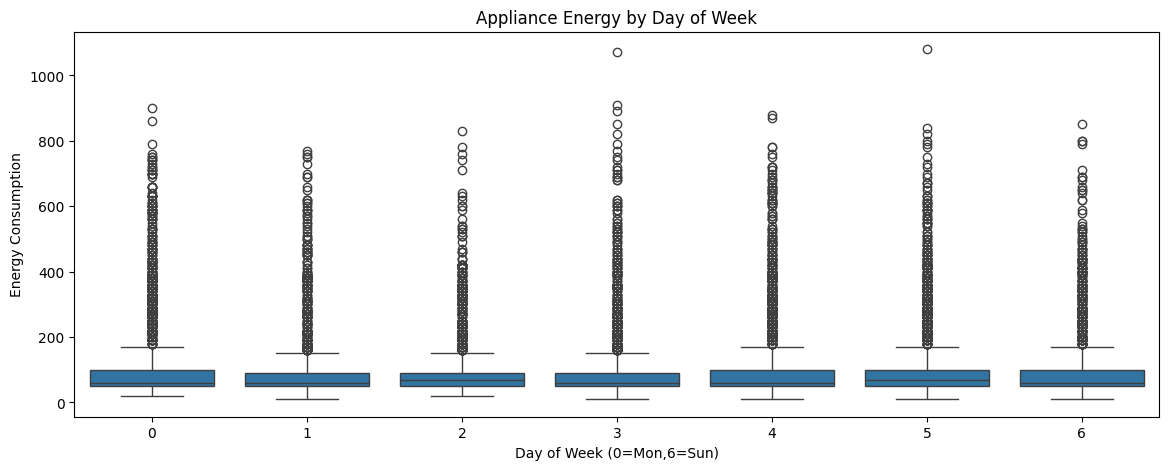

In [15]:
df['hour'] = df['date'].dt.hour
df['weekday'] = df['date'].dt.dayofweek

plt.figure(figsize=(14,5))
sns.boxplot(x='hour', y='Appliances', data=df)
plt.title('Appliance Energy by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Energy Consumption')
plt.show()

plt.figure(figsize=(14,5))
sns.boxplot(x='weekday', y='Appliances', data=df)
plt.title('Appliance Energy by Day of Week')
plt.xlabel('Day of Week (0=Mon,6=Sun)')
plt.ylabel('Energy Consumption')
plt.show()

3. Feature Engineering

In [16]:
temp_cols = ['T1','T2','T3','T4','T5','T6','T7','T8','T9']
rh_cols = ['RH_1','RH_2','RH_3','RH_4','RH_5','RH_6','RH_7','RH_8','RH_9']

In [17]:
df['mean_temp'] = df[temp_cols].mean(axis=1)
df['mean_humidity'] = df[rh_cols].mean(axis=1)

In [18]:
# Drop unneeded columns (including original target, date, sensor details, and possibly lights)
drop_cols = ['date', 'rv1', 'rv2', 'T1','T2','T3','T4','T5','T6','T7','T8','T9',
             'RH_1','RH_2','RH_3','RH_4','RH_5','RH_6','RH_7','RH_8','RH_9']
# Optional: drop 'lights' to avoid leakage; let's keep it for now and see correlation
print(f"Correlation of 'lights' with Appliances: {df['lights'].corr(df['Appliances'])}")
# Drop 'lights' if correlation > 0.7 (feel free to uncomment)
# drop_cols.append('lights')


Correlation of 'lights' with Appliances: 0.1972775602062427


4. Rolling and Lag Features

In [19]:
df_model = df.drop(columns=drop_cols)

In [20]:
df_model['lag_1h'] = df_model['Appliances_log'].shift(6)   # 1 hour lag
df_model['lag_2h'] = df_model['Appliances_log'].shift(12)  # 2 hour lag
df_model['lag_24h'] = df_model['Appliances_log'].shift(144) # 24 hour lag

In [21]:
# — after creating lag_1h, lag_2h, lag_24h on df_model —

# Rolling mean and std over the past hour (6 ten-minute intervals)
df_model['roll_mean_1h'] = df_model['Appliances_log'].rolling(window=6).mean().shift(1)
df_model['roll_std_1h']  = df_model['Appliances_log'].rolling(window=6).std().shift(1)


In [22]:
# --------- ADD NEW FEATURES HERE ---------

# Weekend flag
df_model['is_weekend'] = df_model['weekday'].isin([5,6]).astype(int)

# Rolling means of weather (past hour)
df_model['T_out_roll_mean_1h'] = df_model['T_out'].rolling(window=6).mean().shift(1)
df_model['RH_out_roll_mean_1h'] = df_model['RH_out'].rolling(window=6).mean().shift(1)

# Lagged weather features (1 hour)
df_model['T_out_lag_1h'] = df_model['T_out'].shift(6)
df_model['RH_out_lag_1h'] = df_model['RH_out'].shift(6)

# Interaction terms
df_model['temp_humidity_interaction'] = df_model['mean_temp'] * df_model['mean_humidity']
df_model['dewpoint_minus_temp'] = df_model['Tdewpoint'] - df_model['T_out']

# Drop any NaNs created by these new features
df_model.dropna(subset=['T_out_roll_mean_1h', 'RH_out_roll_mean_1h', 'T_out_lag_1h', 'RH_out_lag_1h'], inplace=True)


In [23]:
# Short- and long-window rolling stats on log target
df_model['roll_mean_30m']       = df_model['Appliances_log'] \
                                      .rolling(window=3).mean().shift(1)
df_model['roll_std_30m']        = df_model['Appliances_log'] \
                                      .rolling(window=3).std().shift(1)
df_model['roll_mean_2h']        = df_model['Appliances_log'] \
                                      .rolling(window=12).mean().shift(1)
df_model['roll_std_2h']         = df_model['Appliances_log'] \
                                      .rolling(window=12).std().shift(1)

# Rolling stats for key weather signals
df_model['T_out_roll_std_2h']   = df_model['T_out'] \
                                      .rolling(window=12).std().shift(1)
df_model['RH_out_roll_mean_2h'] = df_model['RH_out'] \
                                      .rolling(window=12).mean().shift(1)

In [24]:
df_model.dropna(subset=[
    'lag_1h','lag_2h','lag_24h',
    'roll_mean_1h','roll_std_1h',
    'roll_mean_30m','roll_std_30m','roll_mean_2h','roll_std_2h',
    'T_out_roll_mean_1h','RH_out_roll_mean_1h',
    'T_out_roll_std_2h','RH_out_roll_mean_2h',
    'T_out_lag_1h','RH_out_lag_1h'
], inplace=True)


5. Train Test Split & Feature Scaling

In [25]:
# 5. Separate features and target
X = df_model.drop(columns=['Appliances', 'Appliances_log'])
y = df_model['Appliances_log']  # Predict log target

In [26]:
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

Feature matrix shape: (19591, 36)
Target vector shape: (19591,)


In [27]:
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [28]:
y_test_original = np.expm1(y_test)

In [29]:
print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

Train set: (15672, 36), Test set: (3919, 36)


In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

6. Modeling

In [31]:
# 8. Train Linear Regression on log target
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr_log = lr.predict(X_test_scaled)

In [32]:
y_pred_lr = np.expm1(y_pred_lr_log)
y_test_orig = np.expm1(y_test)


In [33]:
mae_lr = mean_absolute_error(y_test_orig, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test_orig, y_pred_lr))
r2_lr = r2_score(y_test_orig, y_pred_lr)

In [34]:
print("Linear Regression Performance:")
print(f" MAE : {mae_lr:.2f} Wh")
print(f" RMSE: {rmse_lr:.2f} Wh")
print(f" R²  : {r2_lr:.3f}")

Linear Regression Performance:
 MAE : 28.32 Wh
 RMSE: 67.93 Wh
 R²  : 0.402


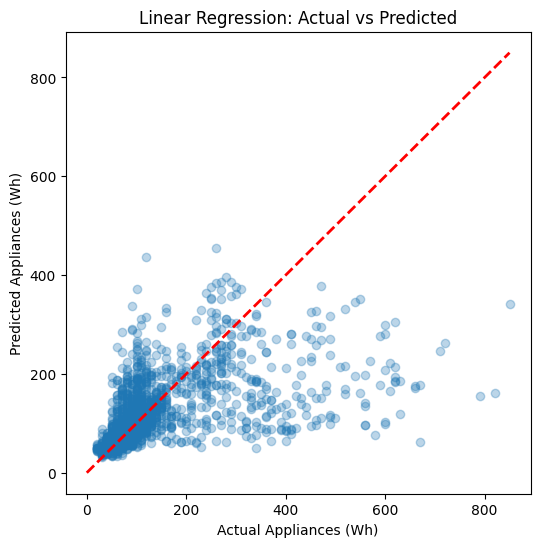

In [35]:
plt.figure(figsize=(6,6))
plt.scatter(y_test_orig, y_pred_lr, alpha=0.3)
plt.plot([0, y_test_orig.max()], [0, y_test_orig.max()], 'r--', lw=2)
plt.xlabel("Actual Appliances (Wh)")
plt.ylabel("Predicted Appliances (Wh)")
plt.title("Linear Regression: Actual vs Predicted")
plt.show()

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train a default Random Forest
rf_default = RandomForestRegressor(random_state=42)
rf_default.fit(X_train, y_train)

# Predict
y_pred_rf_default_log = rf_default.predict(X_test)
y_pred_rf_default = np.expm1(y_pred_rf_default_log)  # Back to original Wh

# Evaluate
mae_rf_default = mean_absolute_error(np.expm1(y_test), y_pred_rf_default)
rmse_rf_default = np.sqrt(mean_squared_error(np.expm1(y_test), y_pred_rf_default))
r2_rf_default = r2_score(np.expm1(y_test), y_pred_rf_default)

print("📊 Default Random Forest Performance:")
print(f"  MAE : {mae_rf_default:.2f} Wh")
print(f"  RMSE: {rmse_rf_default:.2f} Wh")
print(f"  R²  : {r2_rf_default:.3f}")


📊 Default Random Forest Performance:
  MAE : 32.65 Wh
  RMSE: 67.08 Wh
  R²  : 0.417


In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Slimmed parameter grid
param_dist = {
    'n_estimators': [100, 200],        # just two options
    'max_depth': [None, 10, 20],       # shallow trees only
    'min_samples_leaf': [1, 2, 5],     # small leaves
    'max_features': ['sqrt', 'log2']   # two choices
}

random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=10,       # only 10 combos
    cv=3,            # 3-fold CV
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train_scaled, y_train)
print("Best params:", random_search.best_params_)
print("Best CV MAE:", -random_search.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params: {'n_estimators': 200, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 10}
Best CV MAE: 0.2784173334766224


In [38]:
best_rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
best_rf.fit(X_train, y_train)

# Predict on test set
y_pred_log = best_rf.predict(X_test)

# Convert back to original scale
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(y_pred_log)

# Evaluate
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2 = r2_score(y_test_actual, y_pred_actual)

print("📊 Tuned Random Forest Test Performance:")
print(f"  MAE : {mae:.2f} Wh")
print(f"  RMSE: {rmse:.2f} Wh")
print(f"  R²  : {r2:.3f}")


📊 Tuned Random Forest Test Performance:
  MAE : 27.48 Wh
  RMSE: 66.03 Wh
  R²  : 0.435


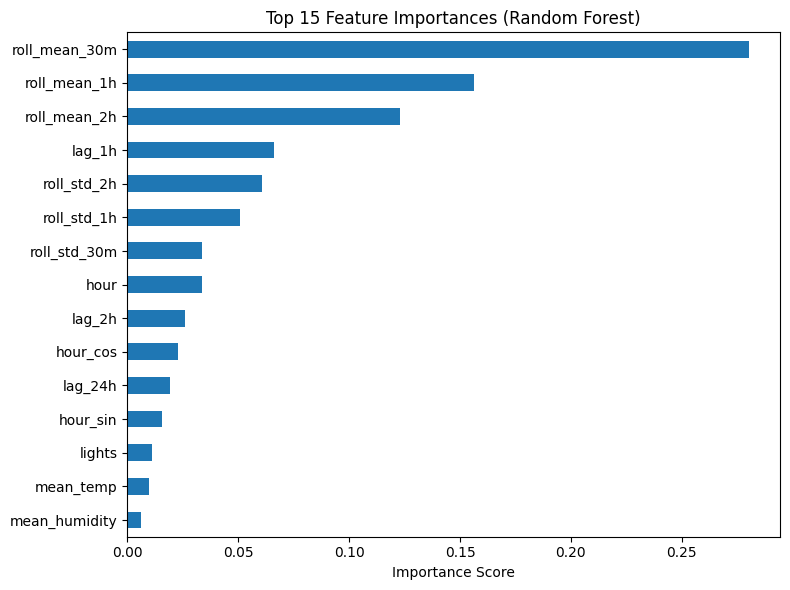

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
importances.sort_values().tail(15).plot(kind='barh', figsize=(8,6))
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


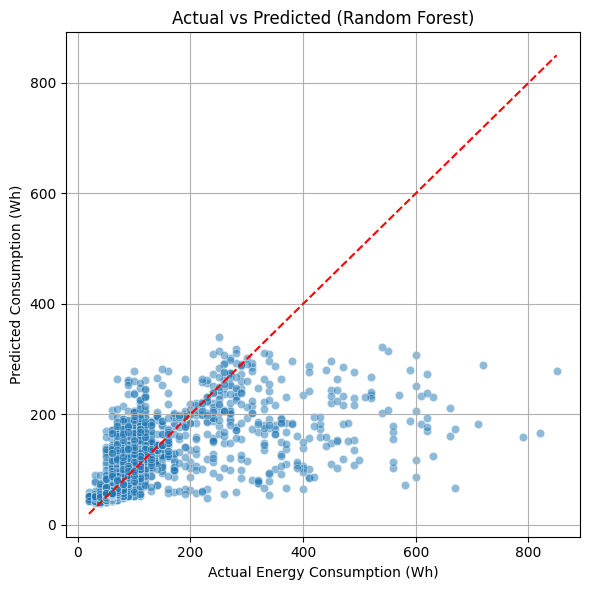

In [40]:
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test_actual, y=y_pred_actual, alpha=0.5)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--')
plt.xlabel("Actual Energy Consumption (Wh)")
plt.ylabel("Predicted Consumption (Wh)")
plt.title("Actual vs Predicted (Random Forest)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [41]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize XGBoost model
xgb_model = XGBRegressor(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train on log-transformed target
xgb_model.fit(X_train, y_train)

# Predict log values
y_pred_log = xgb_model.predict(X_test)

# Convert back to original Wh
y_pred = np.expm1(y_pred_log)

# Evaluate on original scale
mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
r2 = r2_score(y_test_original, y_pred)

print("📊 XGBoost Performance:")
print(f"  MAE : {mae:.2f} Wh")
print(f"  RMSE: {rmse:.2f} Wh")
print(f"  R²  : {r2:.3f}")


📊 XGBoost Performance:
  MAE : 26.77 Wh
  RMSE: 64.23 Wh
  R²  : 0.465


In [42]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

# Base model
xgb = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# Reasonable param grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

# Random search
random_search_xgb = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit
random_search_xgb.fit(X_train_scaled, y_train)

# Output
print("🔍 Best Params (XGBoost):", random_search_xgb.best_params_)
print("📉 Best CV MAE (XGBoost):", -random_search_xgb.best_score_)

# Save tuned model
best_xgb = random_search_xgb.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
🔍 Best Params (XGBoost): {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
📉 Best CV MAE (XGBoost): 0.26730810526347654


In [43]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

xgb_tuned2 = XGBRegressor(
    subsample=0.9,
    reg_lambda=2,
    reg_alpha=0,
    n_estimators=200,       # more trees
    max_depth=6,            # a bit deeper
    learning_rate=0.03,     # lower LR for better convergence
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

xgb_tuned2.fit(X_train, y_train)
y_pred_log = xgb_tuned2.predict(X_test)
y_pred = np.expm1(y_pred_log)

mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
r2 = r2_score(y_test_original, y_pred)

print("📊 XGBoost Tweaked Performance:")
print(f"  MAE : {mae:.4f} Wh")
print(f"  RMSE: {rmse:.4f} Wh")
print(f"  R²  : {r2:.4f}")

📊 XGBoost Tweaked Performance:
  MAE : 26.7527 Wh
  RMSE: 64.1814 Wh
  R²  : 0.4660


In [44]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    random_state=42
)

gbr.fit(X_train, y_train)
y_pred_log_gbr = gbr.predict(X_test)
y_pred_gbr = np.expm1(y_pred_log_gbr)

mae = mean_absolute_error(y_test_original, y_pred_gbr)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_gbr))
r2 = r2_score(y_test_original, y_pred_gbr)

print("📊 GradientBoostingRegressor Performance:")
print(f"  MAE : {mae:.2f} Wh")
print(f"  RMSE: {rmse:.2f} Wh")
print(f"  R²  : {r2:.3f}")


📊 GradientBoostingRegressor Performance:
  MAE : 28.86 Wh
  RMSE: 64.98 Wh
  R²  : 0.453


In [45]:
from lightgbm import LGBMRegressor

lgb_model = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_model.fit(X_train, y_train)
y_pred_log_lgb = lgb_model.predict(X_test)
y_pred_lgb = np.expm1(y_pred_log_lgb)

mae = mean_absolute_error(y_test_original, y_pred_lgb)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_lgb))
r2 = r2_score(y_test_original, y_pred_lgb)

print("📊 LightGBM Performance:")
print(f"  MAE : {mae:.2f} Wh")
print(f"  RMSE: {rmse:.2f} Wh")
print(f"  R²  : {r2:.3f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5674
[LightGBM] [Info] Number of data points in the train set: 15672, number of used features: 36
[LightGBM] [Info] Start training from score 4.309526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [46]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define your model with verbosity off
model = LGBMRegressor(verbose=-1, random_state=42)

# Define your hyperparameter search space
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'num_leaves': [31, 50, 70],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
}

# Initialize RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=25,
    scoring='neg_mean_absolute_error',
    cv=3,
    random_state=42,
    verbose=2,
    n_jobs=-1
)

# Fit on your training data
search.fit(X_train, y_train)

# Print the best params and best score
print("Best params:", search.best_params_)
print("Best CV MAE:", -search.best_score_)


Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best params: {'subsample': 0.7, 'num_leaves': 31, 'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Best CV MAE: 0.26776371448539943


In [47]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Best parameters from tuning
best_params = {
    'subsample': 0.7,
    'num_leaves': 31,
    'n_estimators': 100,
    'max_depth': 4,
    'learning_rate': 0.05,
    'colsample_bytree': 0.7,
    'random_state': 42
}

# Instantiate model with best parameters
best_model = lgb.LGBMRegressor(**best_params)

# Train on full training data
best_model.fit(X_train, y_train)

# Predict on test data
y_pred = best_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Tuned LightGM Regressor")
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²: {r2:.4f}")


Tuned LightGM Regressor
Test MAE: 0.2112
Test RMSE: 0.3339
Test R²: 0.6296


📊 MLP Regressor Performance:
  MAE : 40.29 Wh
  RMSE: 76.96 Wh
  R²  : 0.232


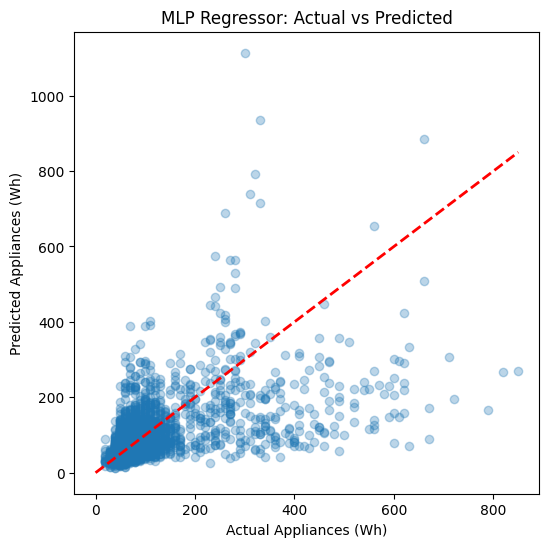

In [48]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Initialize MLPRegressor
mlp = MLPRegressor(
    hidden_layer_sizes=(100,),  # one hidden layer with 100 neurons
    max_iter=500,
    random_state=42,
    early_stopping=True,        # stop early if no improvement
    n_iter_no_change=20,
    learning_rate_init=0.001
)

# Fit on scaled training data
mlp.fit(X_train_scaled, y_train)

# Predict on scaled test data (log scale)
y_pred_log = mlp.predict(X_test_scaled)

# Convert predictions back to original scale
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

# Evaluate
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("📊 MLP Regressor Performance:")
print(f"  MAE : {mae:.2f} Wh")
print(f"  RMSE: {rmse:.2f} Wh")
print(f"  R²  : {r2:.3f}")

# Plot Actual vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.plot([0, y_true.max()], [0, y_true.max()], 'r--', lw=2)
plt.xlabel("Actual Appliances (Wh)")
plt.ylabel("Predicted Appliances (Wh)")
plt.title("MLP Regressor: Actual vs Predicted")
plt.show()


In [49]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [50]:
base_models = [
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42, verbosity=0)),
    ('lgbm', LGBMRegressor(
    n_estimators=250,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.9,
    random_state=42
))
]

# Final estimator can be something simple and robust
from sklearn.linear_model import Ridge

final_estimator = Ridge(alpha=1.0)

In [51]:
stacked_model = StackingRegressor(
    estimators=base_models,
    final_estimator=final_estimator,
    passthrough=True,  # Optional: lets final estimator use original features
    n_jobs=-1,
    cv=5
)

In [52]:
import sklearn
print(sklearn.__version__)

1.6.1


In [53]:
stacked_model.fit(X_train_scaled, y_train)
y_pred = stacked_model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # <-- change here
r2 = r2_score(y_test, y_pred)

print(f"Stacked Model - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

Stacked Model - MAE: 0.2146, RMSE: 0.3337, R²: 0.6300


7. SHAP Engineering

In [54]:
pip install shap

In [55]:
import shap

# Create the SHAP explainer
explainer = shap.TreeExplainer(best_model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)


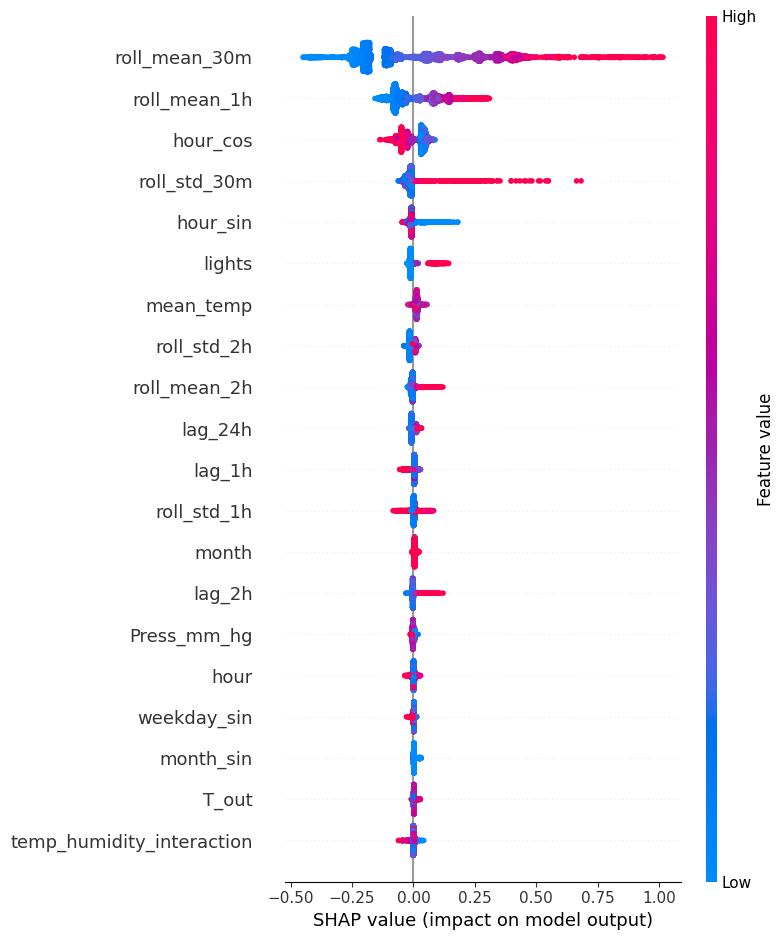

In [56]:
# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test)

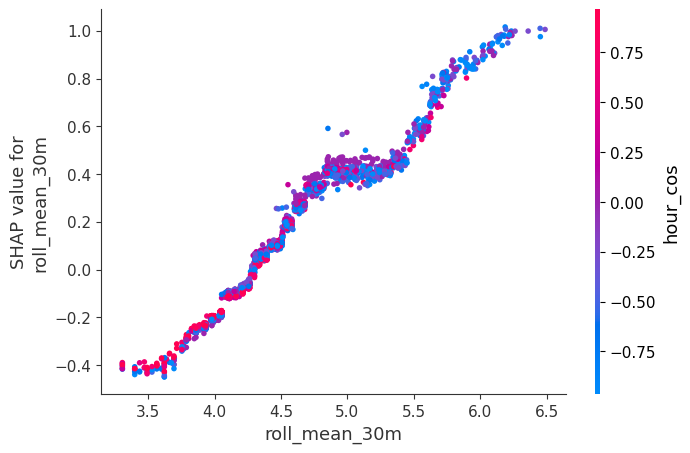

In [57]:
shap.dependence_plot("roll_mean_30m", shap_values, X_test)

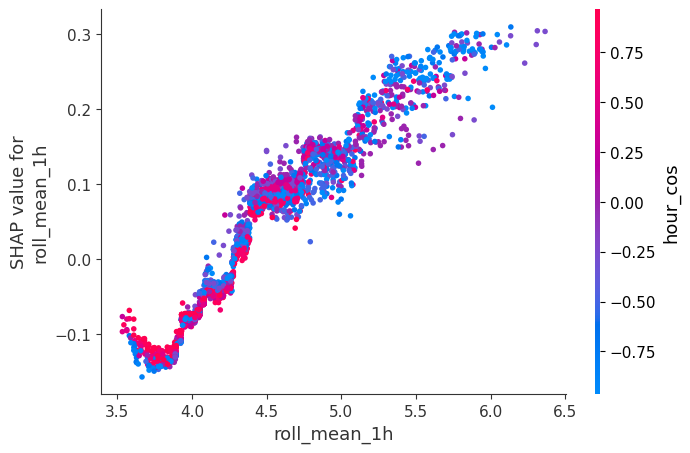

In [58]:
shap.dependence_plot("roll_mean_1h", shap_values, X_test)


In [59]:
# Just to be safe: ensure test set has the same columns in same order
X_test_shap = X_test[X_train.columns]  # enforce same structure

# Add check_additivity=False to avoid error if minor numerical diff exists
shap.TreeExplainer(best_model)
shap_values = explainer(X_test_shap, check_additivity=False)

In [60]:
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
shap_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean_Abs_SHAP': mean_abs_shap
}).sort_values(by='Mean_Abs_SHAP', ascending=False)

shap_df.head(20)

Feature  Mean_Abs_SHAP
30              roll_mean_30m       0.234144
21               roll_mean_1h       0.090335
11                   hour_cos       0.042738
31               roll_std_30m       0.027456
10                   hour_sin       0.017740
0                      lights       0.016822
16                  mean_temp       0.011999
33                roll_std_2h       0.010452
32               roll_mean_2h       0.010350
20                    lag_24h       0.009189
18                     lag_1h       0.005869
22                roll_std_1h       0.005218
9                       month       0.005052
19                     lag_2h       0.004943
2                 Press_mm_hg       0.003685
7                        hour       0.003576
14                weekday_sin       0.003098
12                  month_sin       0.002725
1                       T_out       0.002503
28  temp_humidity_interaction       0.001996

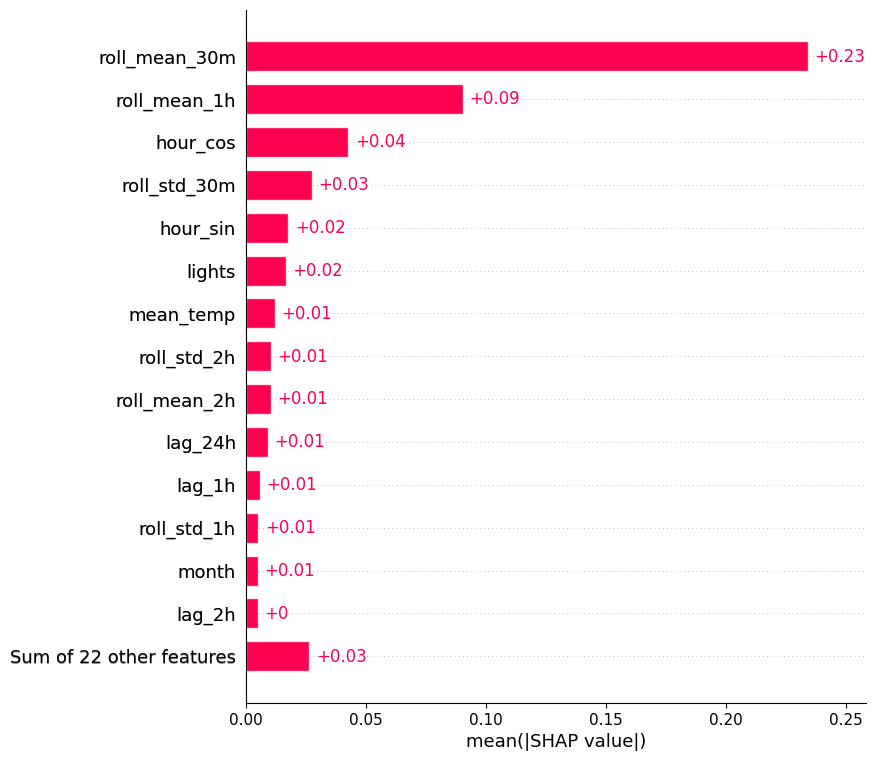

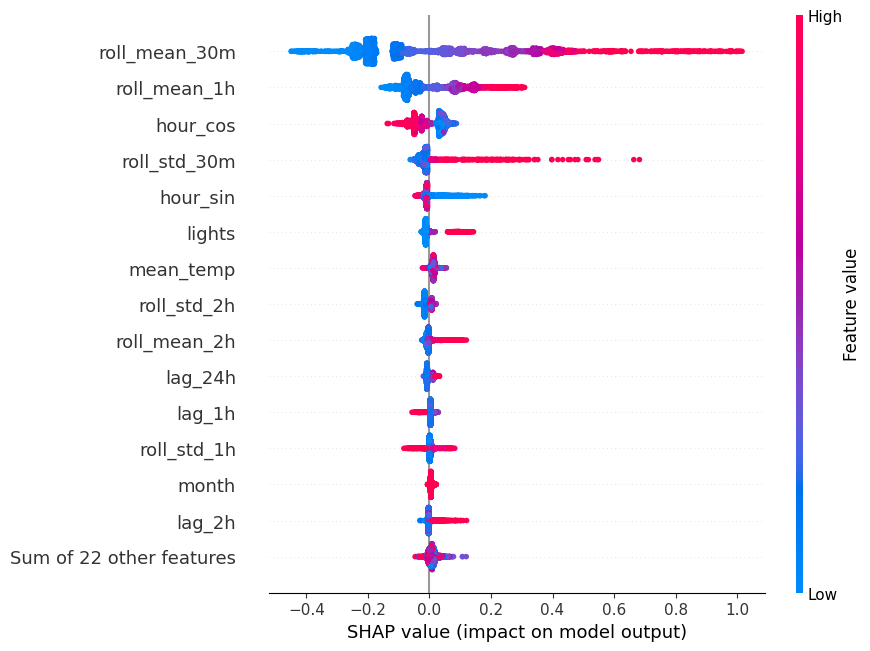

In [61]:
# SHAP summary bar plot (if not yet done)
shap.plots.bar(shap_values, max_display=15)

# SHAP beeswarm plot (shows direction of impact too)
shap.plots.beeswarm(shap_values, max_display=15)

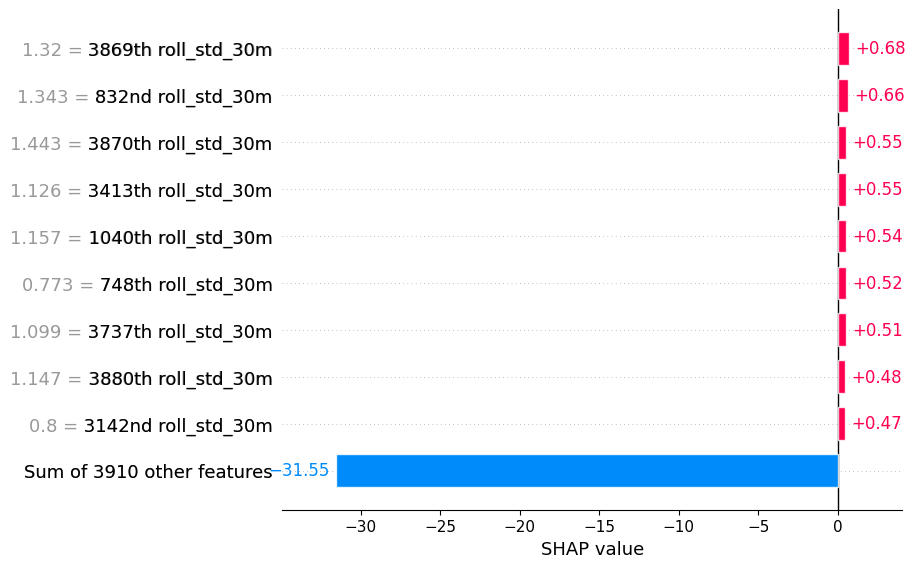

In [62]:
shap.plots.bar(shap_values[:, "roll_std_30m"])

In [63]:
# Choose a test instance, say index 10
idx = 10

# Force plot (requires JS rendering)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values[idx].values,
    features=X_test.iloc[idx],
    feature_names=X_test.columns
)


In [64]:
weak = shap_df[shap_df.Mean_Abs_SHAP < 0.0001]['Feature'].tolist()
print("Weak features:", weak)

Weak features: ['RH_out_roll_mean_2h', 'RH_out_roll_mean_1h', 'is_weekend', 'Windspeed', 'weekday_cos']


In [65]:
# low_importance = ['RH_out_roll_mean_2h', 'RH_out_roll_mean_1h', 'is_weekend', 'Windspeed', 'weekday_cos', 'Press_mm_hg', 'month', 'month_sin', 'mean_humidity']
low_importance = ['Press_mm_hg', 'month', 'month_sin', 'mean_humidity']

X_train_reduced = X_train.drop(columns=low_importance)
X_test_reduced = X_test.drop(columns=low_importance)

Re-Evaluate without weak feautures

In [66]:
best_model.fit(X_train_reduced, y_train)

# Predict on test data
y_pred = best_model.predict(X_test_reduced)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Tuned LightGM Regressor")
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²: {r2:.4f}")

Tuned LightGM Regressor
Test MAE: 0.2103
Test RMSE: 0.3329
Test R²: 0.6317


 94%|=================== | 3693/3919 [00:11<00:00]       

         Feature  Mean_Abs_SHAP
0   T_out_lag_1h       0.614692
1         lights       0.017113
2       hour_cos       0.009957
3          T_out       0.007287
4    roll_std_1h       0.006807
5       hour_sin       0.004911
6        weekday       0.002135
7        lag_24h       0.002102
8           hour       0.001912
9     Visibility       0.000004
10     Tdewpoint       0.000004
11   Press_mm_hg       0.000000
12        RH_out       0.000000
13     month_sin       0.000000
14   weekday_sin       0.000000
15   weekday_cos       0.000000
16     mean_temp       0.000000
17     month_cos       0.000000
18     Windspeed       0.000000
19         month       0.000000
Pos feature: hour_cos
Top negatively correlated (feature increases -> SHAP decreases):
hour_cos       -0.904357
roll_std_1h    -0.795668
lag_24h        -0.784134
T_out          -0.384004
hour_sin        0.066912
Tdewpoint       0.090878
Visibility      0.188713
T_out_lag_1h    0.434727
hour            0.575510
weekday         

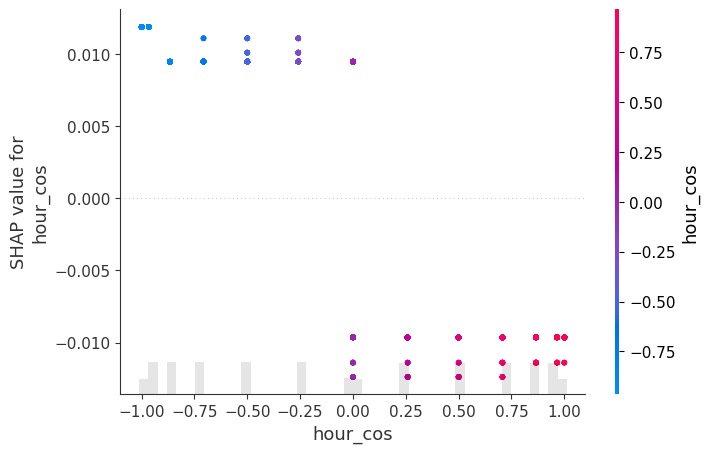

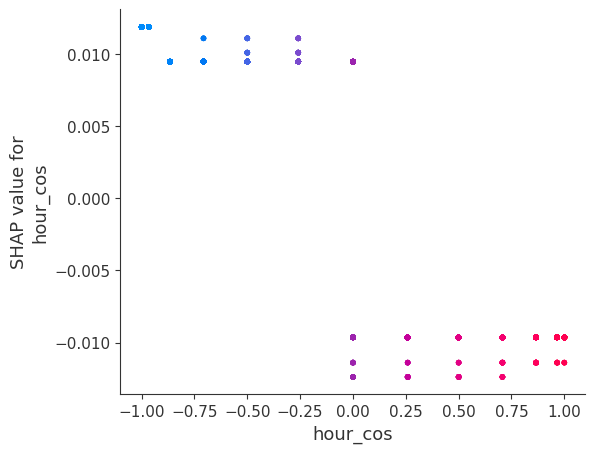

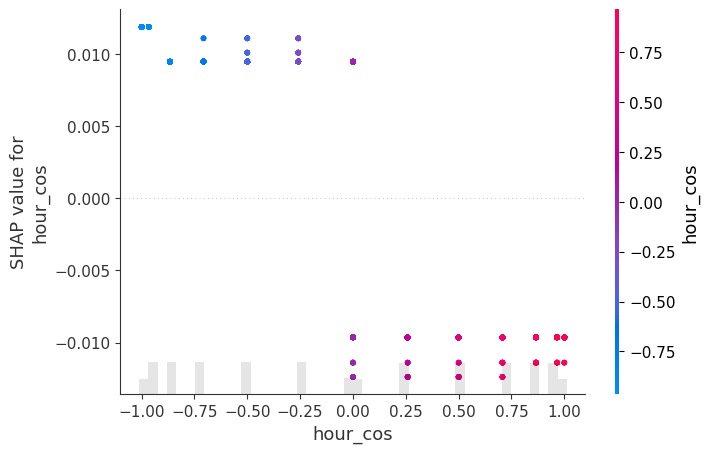

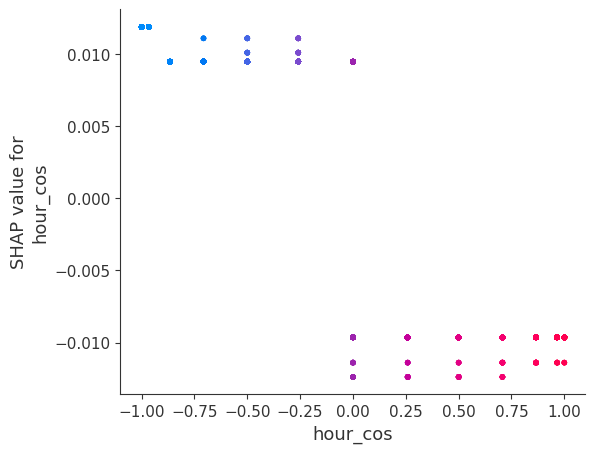

In [67]:
import shap
import numpy as np
import pandas as pd

# make sure best_model is the trained LGBM (the one you used to compute shap_df)
# ensure X_train and X_test are the unscaled DataFrames used to train best_model

# Create Explainer (use same data shape/model as training)
explainer = shap.Explainer(best_model, X_train)   # if you used unscaled X_train when fitting best_model

# Compute SHAP values (disable strict additivity check if necessary)
shap_values = explainer(X_test, check_additivity=False)

# Build a DataFrame of mean abs SHAP (already done but safe)
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
shap_df = pd.DataFrame({'Feature': X_test.columns, 'Mean_Abs_SHAP': mean_abs_shap})
shap_df = shap_df.sort_values('Mean_Abs_SHAP', ascending=False).reset_index(drop=True)
print(shap_df.head(20))

# Choose top positive-impact feature (we'll pick hour_cos if present)
pos_feat = 'hour_cos' if 'hour_cos' in X_test.columns else shap_df.loc[0,'Feature']
print("Pos feature:", pos_feat)

# Find a candidate negative-impact feature:
# We compute correlation between each feature and its SHAP values to find features where higher feature -> negative SHAP on average.
corrs = {}
for i, f in enumerate(X_test.columns):
    corr = np.corrcoef(X_test[f].values, shap_values.values[:, i])[0,1]
    corrs[f] = corr
corr_ser = pd.Series(corrs).sort_values()
print("Top negatively correlated (feature increases -> SHAP decreases):")
print(corr_ser.head(10))

neg_feat = corr_ser.index[0]   # most negative correlation
print("Neg feature:", neg_feat)

# Dependence plots
shap.plots.scatter(shap_values[:, pos_feat], color=shap_values[:, 'hour_cos'] if 'hour_cos' in X_test.columns else None, show=True)
shap.dependence_plot(pos_feat, shap_values.values, X_test, interaction_index='hour_cos' if 'hour_cos' in X_test.columns else None)

shap.plots.scatter(shap_values[:, neg_feat], color=shap_values[:, pos_feat], show=True)
shap.dependence_plot(neg_feat, shap_values.values, X_test, interaction_index=pos_feat)


In [68]:
# Mean signed SHAP value per feature
mean_signed_shap = shap_values.values.mean(axis=0)

# Combine into DataFrame with feature names
signed_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean_SHAP': mean_signed_shap
}).sort_values(by='Mean_SHAP')

# Show most negative
signed_df.head(10)


Feature  Mean_SHAP
1        T_out  -0.006143
0       lights  -0.005698
10    hour_sin  -0.002420
7         hour  -0.000261
20     lag_24h  -0.000077
5   Visibility  -0.000004
6    Tdewpoint  -0.000004
3       RH_out   0.000000
4    Windspeed   0.000000
9        month   0.000000

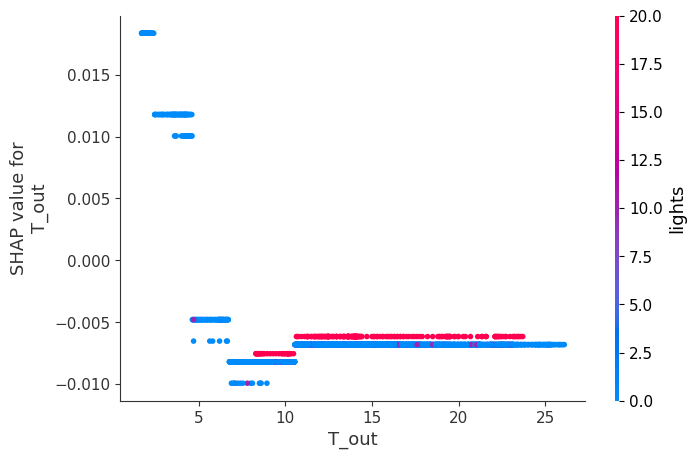

In [69]:
shap.dependence_plot('T_out', shap_values.values, X_test)

In [70]:
import numpy as np

# Actuals in original scale
y_true = np.expm1(y_test)

# Indices of samples with:
idx_high = y_true.idxmax()  # highest actual consumption
idx_low = y_true.idxmin()   # lowest actual consumption
idx_median = y_true.sub(y_true.median()).abs().idxmin()  # closest to median

print(f"High idx: {idx_high}, Low idx: {idx_low}, Median idx: {idx_median}")


High idx: 19582, Low idx: 15878, Median idx: 15854


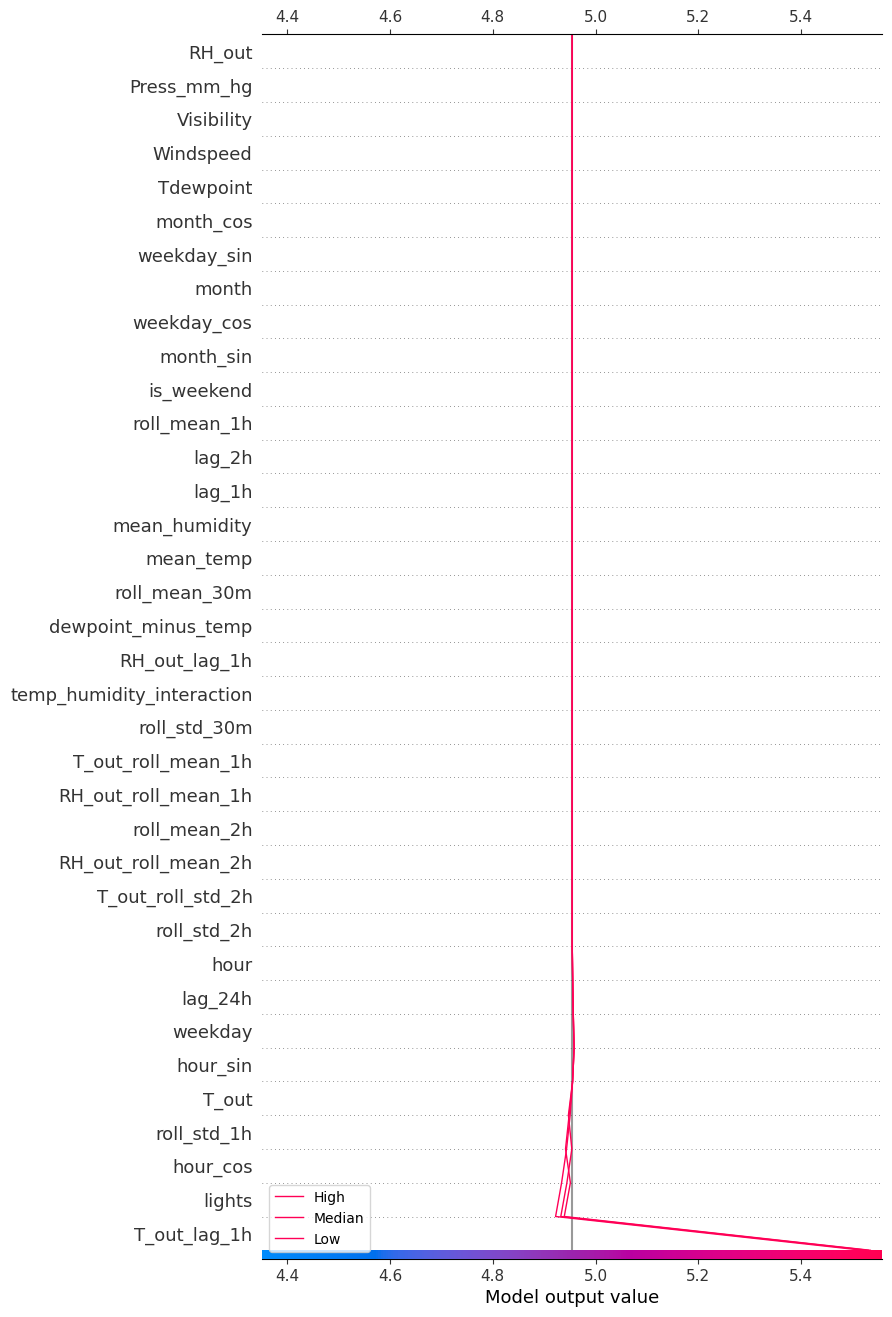

In [71]:
# y_true is a Series indexed like original df (same as X_test)
y_true = np.expm1(y_test)

# Find original indices of high, median, low target values
idx_high_orig = y_true.idxmax()
idx_low_orig = y_true.idxmin()
idx_median_orig = (y_true - y_true.median()).abs().idxmin()

# Convert original indices to positional indices in X_test
pos_high = X_test.index.get_loc(idx_high_orig)
pos_low = X_test.index.get_loc(idx_low_orig)
pos_median = X_test.index.get_loc(idx_median_orig)

shap.initjs()
shap.decision_plot(
    explainer.expected_value,
    shap_values.values[[pos_high, pos_median, pos_low]],
    X_test.iloc[[pos_high, pos_median, pos_low]],  # use iloc here for positional
    feature_display_range=slice(None),
    legend_labels=["High", "Median", "Low"]
)


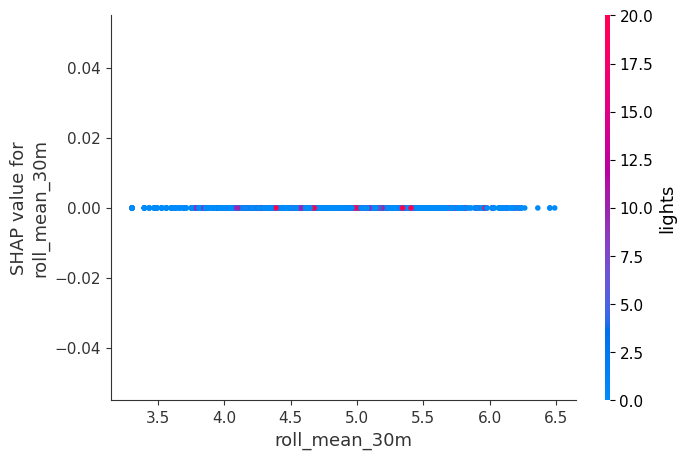

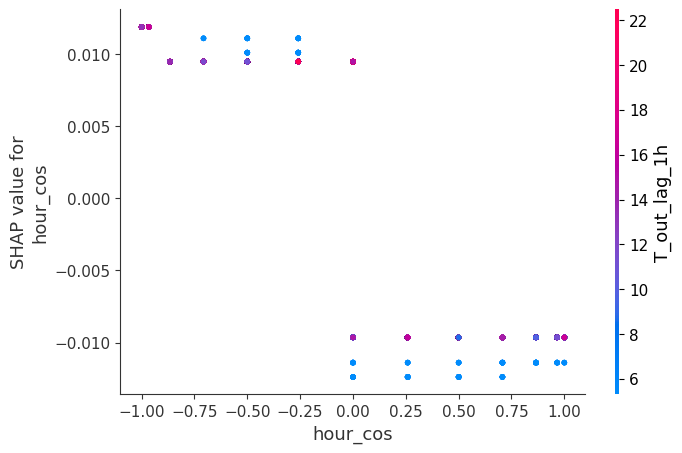

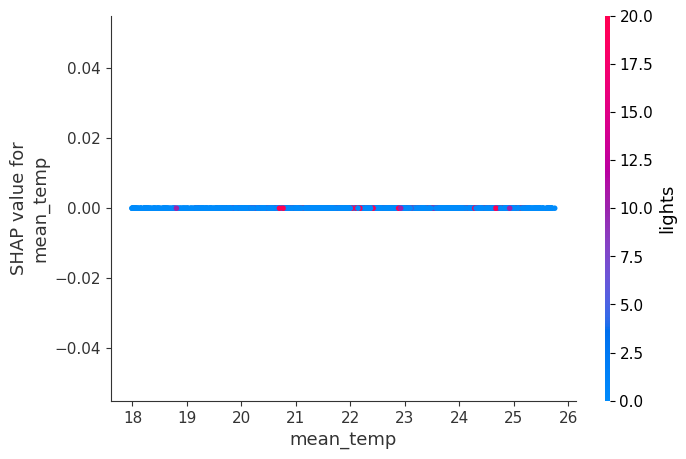

In [72]:
shap.dependence_plot('roll_mean_30m', shap_values.values, X_test)
shap.dependence_plot('hour_cos', shap_values.values, X_test)
shap.dependence_plot('mean_temp', shap_values.values, X_test)

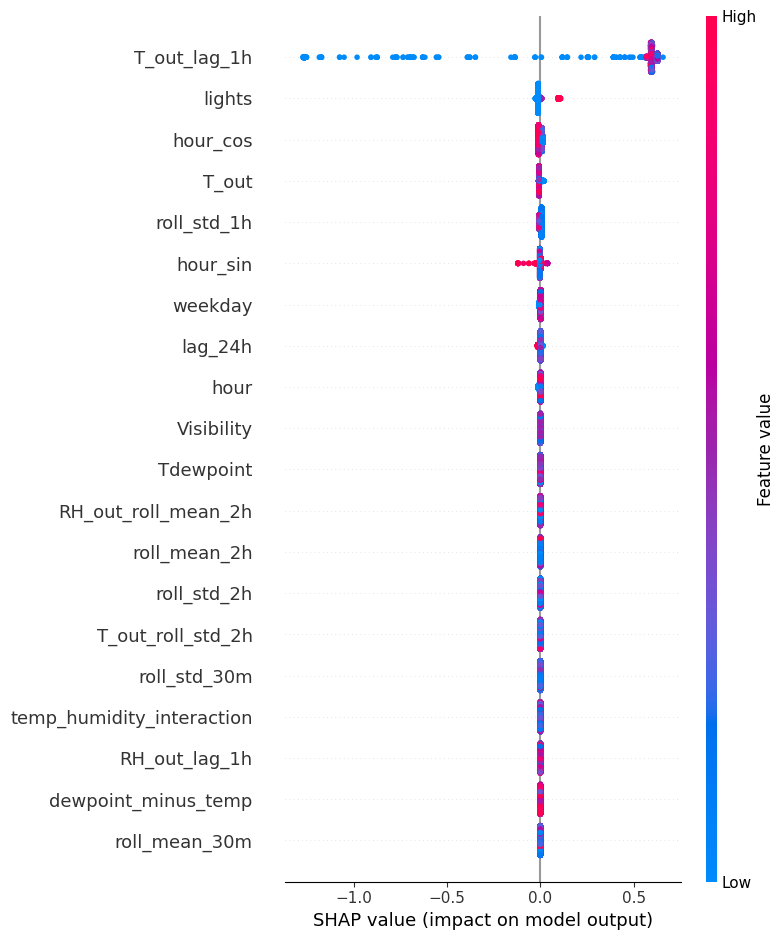

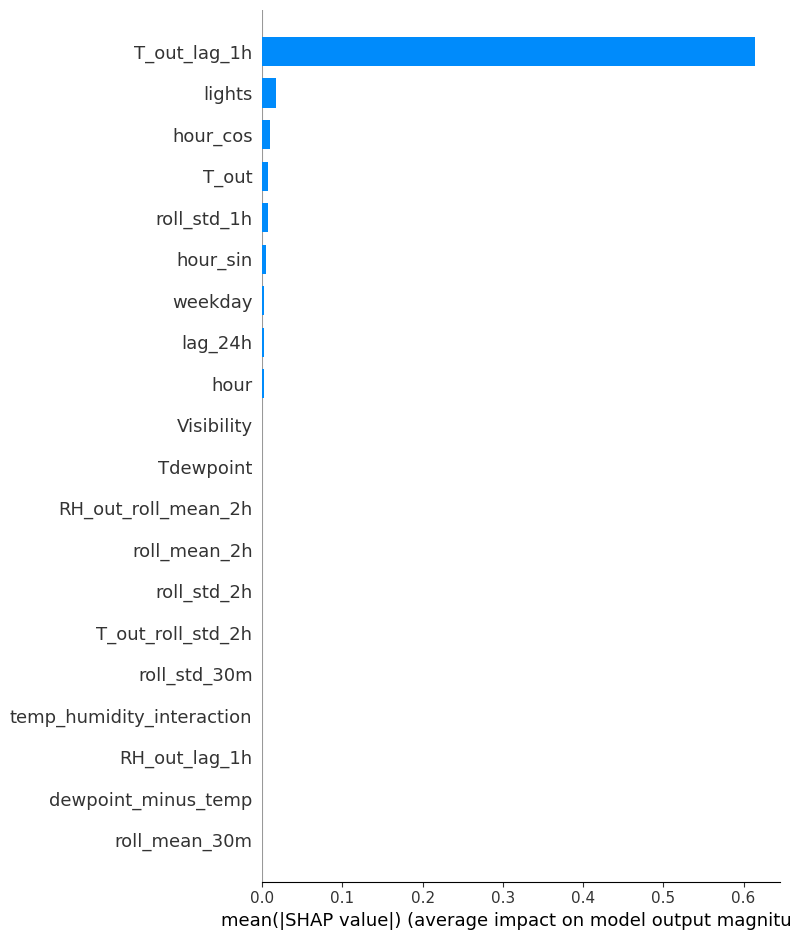

In [73]:
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')